<a href="https://colab.research.google.com/github/mralamdari/Machine_Learning_Projects/blob/main/Advanced_Feature_Engineering_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# for data processing and manipulation
import pandas as pd
import numpy as np
import os
# scikit-learn modules for feature selection and model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [10]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d merishnasuwal/breast-cancer-prediction-dataset
!unzip \*.zip && rm .zip

breast-cancer-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  breast-cancer-prediction-dataset.zip
replace Breast_cancer_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
rm: cannot remove '.zip': No such file or directory


In [14]:
# Load the dataset
df = pd.read_csv('/content/Breast_cancer_data.csv')

# Print datatypes
print(df.dtypes)

# Describe columns
df.describe(include='all')

mean_radius        float64
mean_texture       float64
mean_perimeter     float64
mean_area          float64
mean_smoothness    float64
diagnosis            int64
dtype: object


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


In [15]:
df.isna().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

In [16]:
def fit_model(X, Y):
    '''Use a RandomForestClassifier for this problem.'''

    # define the model to use
    model = RandomForestClassifier(criterion='entropy', random_state=47)

    # Train the model
    model.fit(X, Y)

    return model

In [17]:
def calculate_metrics(model, X_test_scaled, Y_test):
    '''Get model evaluation metrics on the test set.'''

    # Get model predictions
    y_predict_r = model.predict(X_test_scaled)

    # Calculate evaluation metrics for assesing performance of the model.
    roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r)
    rec = recall_score(Y_test, y_predict_r)
    f1 = f1_score(Y_test, y_predict_r)

    return acc, roc, prec, rec, f1

In [18]:
def train_and_get_metrics(X, Y):
    '''Train a Random Forest Classifier and get evaluation metrics'''

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    model = fit_model(X_train_scaled, Y_train)

    # Make predictions on test dataset and calculate metrics.
    roc, acc, prec, rec, f1 = calculate_metrics(model, X_test_scaled, Y_test)

    return acc, roc, prec, rec, f1

In [19]:
def evaluate_model_on_features(X, Y):
    '''Train model and display evaluation metrics.'''

    # Train the model, predict values and get metrics
    acc, roc, prec, rec, f1 = train_and_get_metrics(X, Y)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])

    return display_df

In [22]:

# Split feature and target vectors
X = df.drop("diagnosis", 1)
Y = df["diagnosis"]

# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(X, Y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
results.head()

<ipython-input-22-56e6f124e4a4>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop("diagnosis", 1)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.912698,0.921053,0.931507,0.944444,0.937931,5


#Correlation Matrix
It is a good idea to calculate and visualize the correlation matrix of a data frame to see which features have high correlation. You can do that with just a few lines as shown below. The Pandas corr() method computes the Pearson correlation by default and you will plot it with Matlab PyPlot and Seaborn. The darker blue boxes show features with high positive correlation while white ones indicate high negative correlation. The diagonals will have 1's because the feature is mapped on to itself.

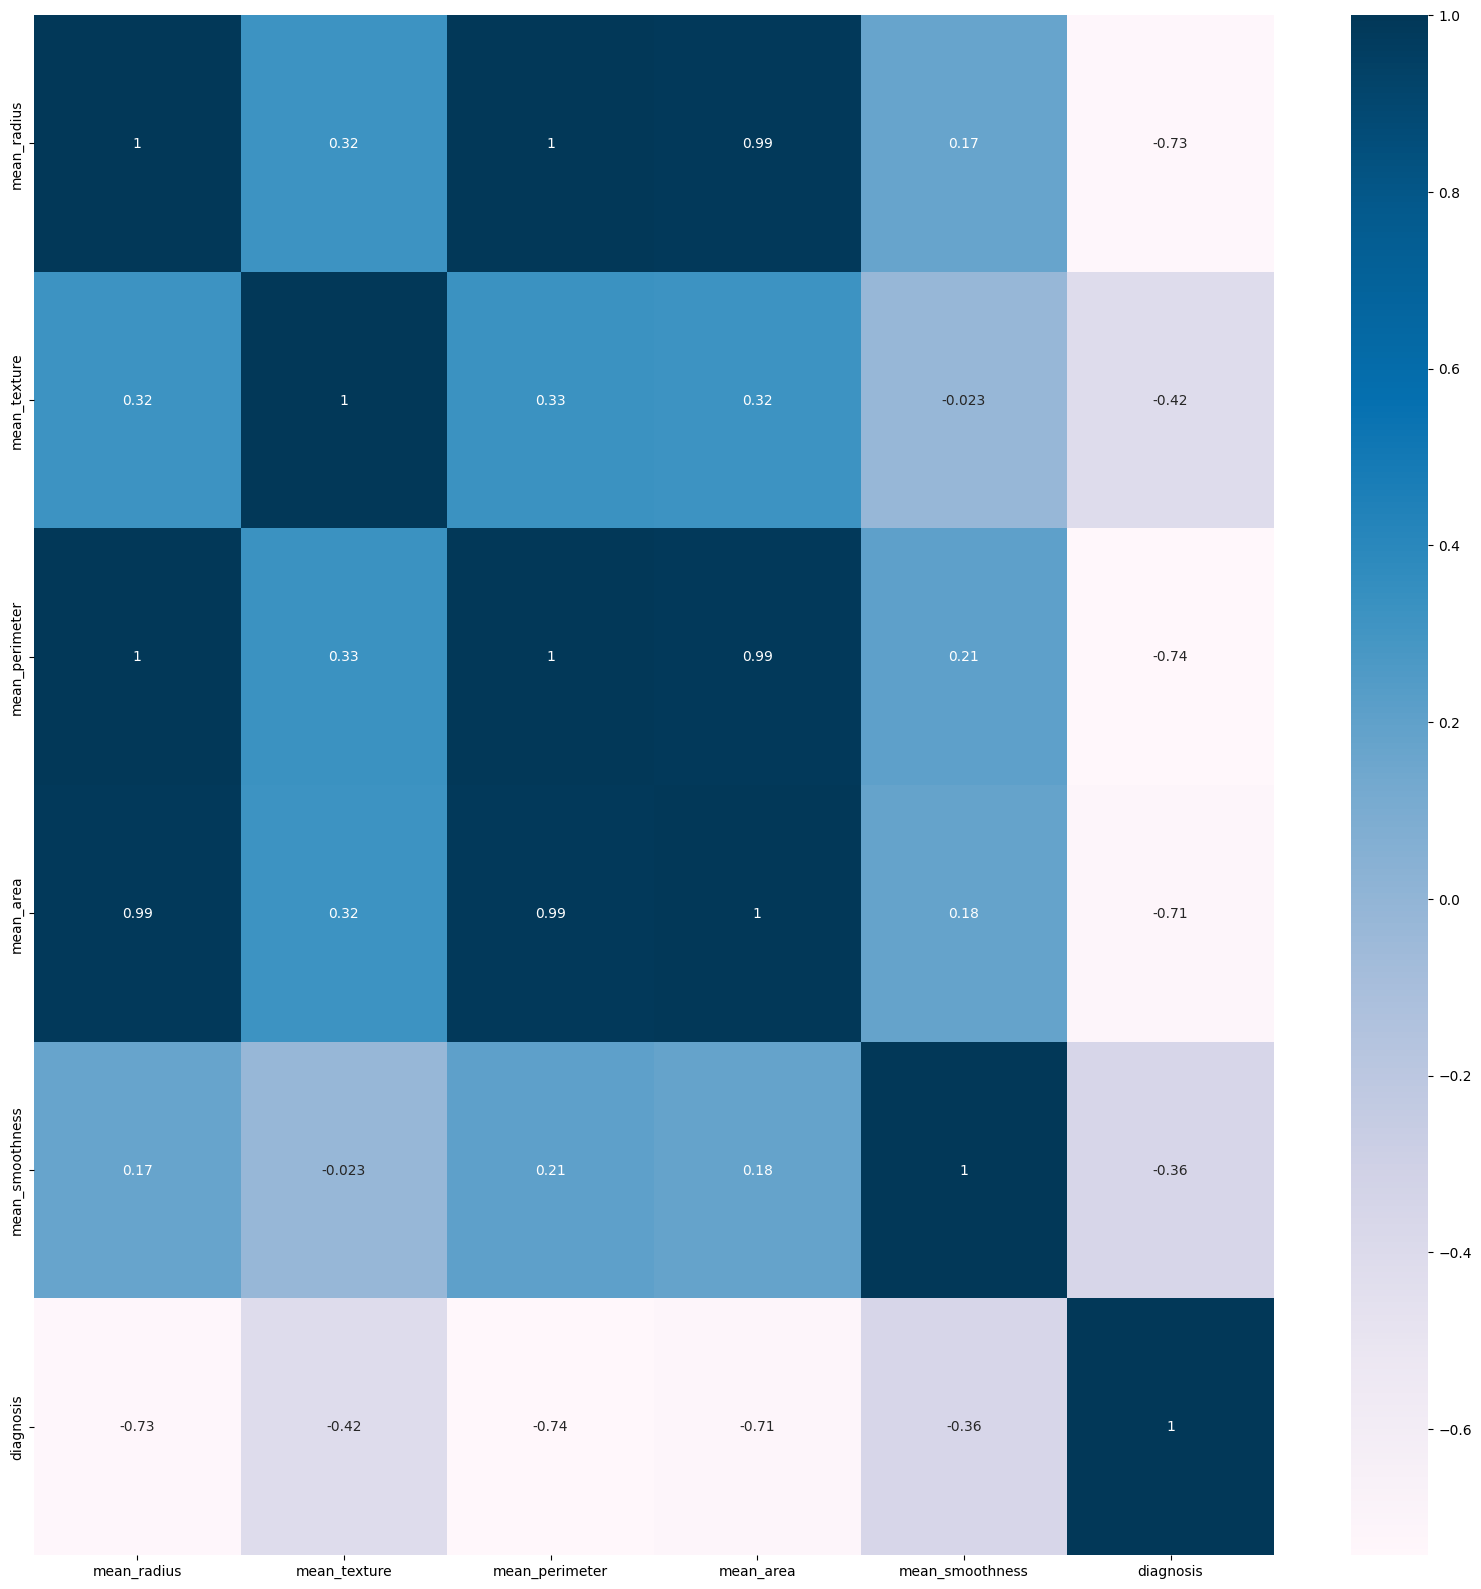

In [23]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate correlation matrix
cor = df.corr()

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

#Filter Methods
Let's start feature selection with filter methods. This type of feature selection uses statistical methods to rank a given set of features. Moreover, it does this ranking regardless of the model you will be training on (i.e. you only need the feature values). When using these, it is important to note the types of features and target variable you have. Here are a few examples:

Pearson Correlation (numeric features - numeric target, exception: when target is 0/1 coded)
ANOVA f-test (numeric features - categorical target)
Chi-squared (categorical features - categorical target)
Let's use some of these in the next cells.

Correlation with the target variable
Let's start by determining which features are strongly correlated with the diagnosis (i.e. the target variable). Since we have numeric features and our target, although categorical, is 0/1 coded, we can use Pearson correlation to compute the scores for each feature. This is also categorized as supervised feature selection because we're taking into account the relationship of each feature with the target variable. Moreover, since only one variable's relationship to the target is taken at a time, this falls under univariate feature selection.

In [25]:
# Get the absolute value of the correlation
cor_target = abs(cor["diagnosis"])

# Select highly correlated features (thresold = 0.2)
relevant_features = cor_target[cor_target>0.2]

# Collect the names of the features
names = [index for index, value in relevant_features.iteritems()]

# Drop the target variable from the results
names.remove('diagnosis')

# Display the results
print(names)

['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']


<ipython-input-25-d4df44400761>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  names = [index for index, value in relevant_features.iteritems()]


In [26]:
# Evaluate the model with new features
strong_features_eval_df = evaluate_model_on_features(df[names], Y)
strong_features_eval_df.index = ['Strong features']

# Append to results and display
results = results.append(strong_features_eval_df)
results.head()

<ipython-input-26-4512a738f2bf>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(strong_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Strong features,0.912698,0.921053,0.931507,0.944444,0.937931,5


#Correlation with other features
You will now eliminate features which are highly correlated with each other. This helps remove redundant features thus resulting in a simpler model. Since the scores are calculated regardless of the target variable, this can be categorized under unsupervised feature selection.

For this, you will plot the correlation matrix of the features selected previously. Let's first visualize the correlation matrix again.

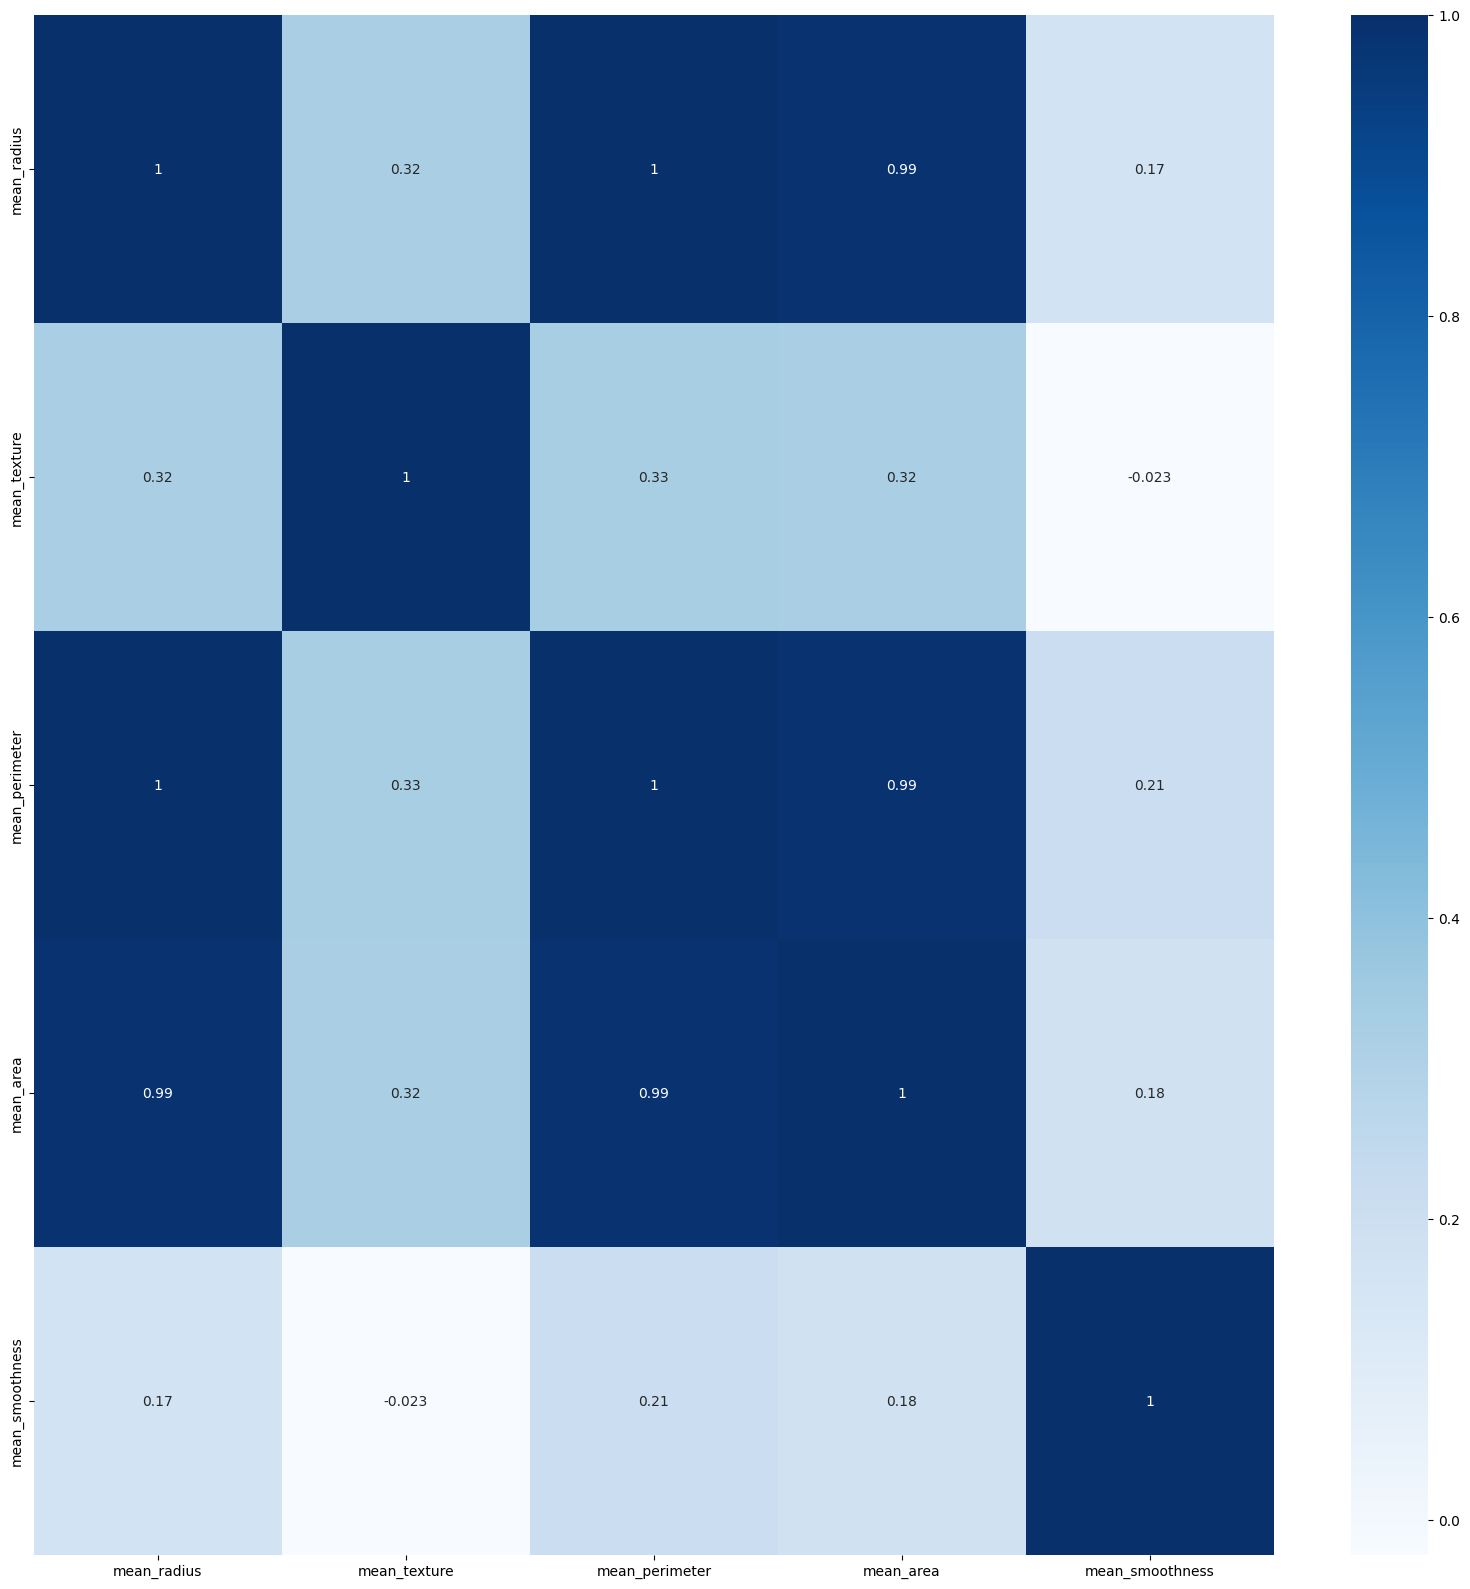

In [27]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate the correlation matrix for target relevant features that you previously determined
new_corr = df[names].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

You will see that radius_mean is highly correlated to radius worst, perimeter_worst, and area_worst. You can retain radius_mean and remove the rest of the features highly correlated to it.

Moreover, concavity_mean is highly correlated to concave points_mean. You will remove concave points_mean and retain concavity_mean from your set of features.

This is a more magnified view of the features that are highly correlated to each other.

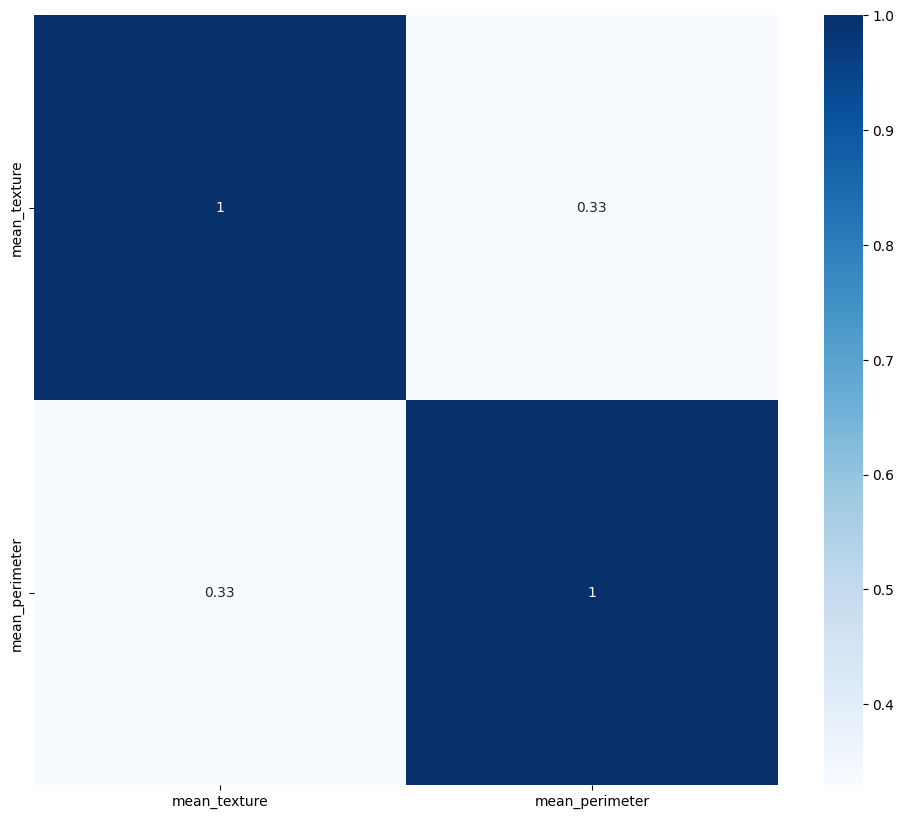

In [29]:
# Set figure size
plt.figure(figsize=(12,10))

# Select a subset of features
new_corr = df[['mean_texture', 'mean_perimeter']].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

You will now evaluate the model on the features selected based on your observations. You can see that the metrics show the same values as when it was using 25 features. This indicates that you can get the same model performance even if you reduce the number of features. In other words, the 4 features you removed were indeed redundant and you only needed the ones you retained.

In [30]:
# Remove the features with high correlation to other features
subset_feature_corr_names = [x for x in names if x not in ['perimeter_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavepoints_mean']]

# Calculate and check evaluation metrics
subset_feature_eval_df = evaluate_model_on_features(df[subset_feature_corr_names], Y)
subset_feature_eval_df.index = ['Subset features']

# Append to results and display
results = results.append(subset_feature_eval_df)
results.head(n=10)

<ipython-input-30-2c99aab04f50>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_feature_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Strong features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Subset features,0.912698,0.921053,0.931507,0.944444,0.937931,5


#Univariate Selection with Sci-Kit Learn
Sci-kit learn offers more filter methods in its feature selection module. Moreover, it also has convenience methods for how you would like to filter the features. You can see the available options here in the official docs.

For this exercise, you will compute the ANOVA F-values to select the top 20 features using SelectKBest().

In [33]:
def univariate_selection():

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # User SelectKBest to select top 2 features based on f-test
    selector = SelectKBest(f_classif, k=2)

    # Fit to scaled data, then transform it
    X_new = selector.fit_transform(X_train_scaled, Y_train)

    # Print the results
    feature_idx = selector.get_support()
    for name, included in zip(df.drop("diagnosis",1 ).columns, feature_idx):
        print("%s: %s" % (name, included))

    # Drop the target variable
    feature_names = df.drop("diagnosis",1 ).columns[feature_idx]

    return feature_names

univariate_feature_names = univariate_selection()

mean_radius: True
mean_texture: False
mean_perimeter: True
mean_area: False
mean_smoothness: False


<ipython-input-33-7cc68c6b534a>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  for name, included in zip(df.drop("diagnosis",1 ).columns, feature_idx):
<ipython-input-33-7cc68c6b534a>:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis",1 ).columns[feature_idx]


In [34]:
# Calculate and check model metrics
univariate_eval_df = evaluate_model_on_features(df[univariate_feature_names], Y)
univariate_eval_df.index = ['F-test']

# Append to results and display
results = results.append(univariate_eval_df)
results.head(n=10)

<ipython-input-34-50b875575d3b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(univariate_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Strong features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Subset features,0.912698,0.921053,0.931507,0.944444,0.937931,5
F-test,0.849206,0.859649,0.888889,0.888889,0.888889,2


#Wrapper Methods
Wrapper methods use a model to measure the effectiveness of a particular subset of features. As mentioned in class, one approach is to remove or add features sequentially. You can either start with 1 feature and gradually add until no improvement is made (forward selection), or do the reverse (backward selection). That can be done with the SequentialFeatureSelector class which uses k-fold cross validation scores to decide which features to add or remove. Recursive Feature Elimination is similar to backwards elimination but uses feature importance scores to prune the number of features. You can also specify how many features to remove at each iteration of the recursion. Let's use this as the wrapper for our model below.

##Recursive Feature Elimination
You used the RandomForestClassifier as the model algorithm for which features should be selected. Now, you will use Recursive Feature Elimination, which wraps around the selected model to perform feature selection. This time, you can repeat the same task of selecting the top 20 features using RFE instead of SelectKBest.

In [38]:
def run_rfe():

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the model
    model = RandomForestClassifier(criterion='entropy', random_state=47)

    # Wrap RFE around the model
    rfe = RFE(model)

    # Fit RFE
    rfe = rfe.fit(X_train_scaled, Y_train)
    feature_names = df.drop("diagnosis",1).columns[rfe.get_support()]

    return feature_names

rfe_feature_names = run_rfe()



<ipython-input-38-570582cefe00>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis",1).columns[rfe.get_support()]


In [39]:
# Calculate and check model metrics
rfe_eval_df = evaluate_model_on_features(df[rfe_feature_names], Y)
rfe_eval_df.index = ['RFE']

# Append to results and display
results = results.append(rfe_eval_df)
results.head(n=10)

<ipython-input-39-610d3cebc3c6>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(rfe_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Strong features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Subset features,0.912698,0.921053,0.931507,0.944444,0.937931,5
F-test,0.849206,0.859649,0.888889,0.888889,0.888889,2
RFE,0.813492,0.833333,0.853333,0.888889,0.870748,2


#Embedded Methods
Some models already have intrinsic properties that select the best features when it is constructed. With that, you can simply access these properties to get the scores for each feature. Let's look at some examples in the following sections.

##Feature Importances
Feature importance is already built-in in scikit-learn’s tree based models like RandomForestClassifier. Once the model is fit, the feature importance is available as a property named feature_importances_.

You can use SelectFromModel to select features from the trained model based on a given threshold.

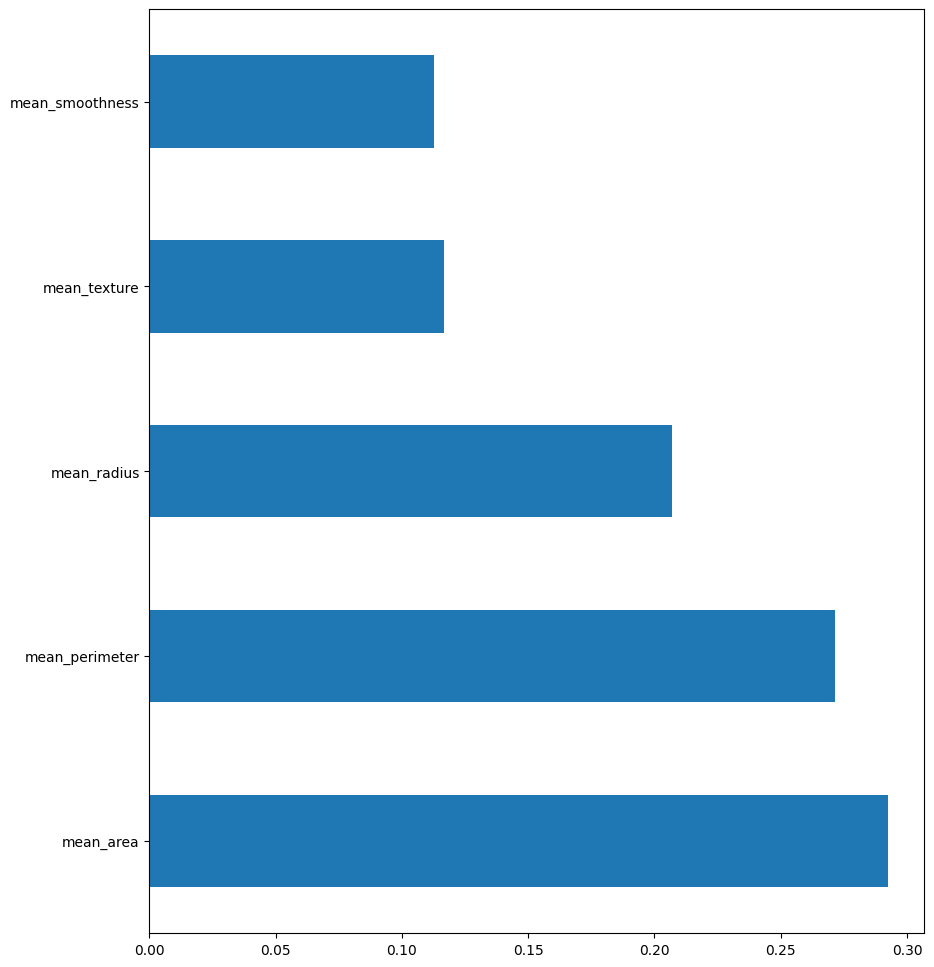

<ipython-input-40-f7c3f84f54be>:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis",1 ).columns[feature_idx]


In [40]:
def feature_importances_from_tree_based_model_():

    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # Define the model to use
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestClassifier()
    model = model.fit(X_train_scaled,Y_train)

    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()

    return model


def select_features_from_model(model):

    model = SelectFromModel(model, prefit=True, threshold=0.013)
    feature_idx = model.get_support()
    feature_names = df.drop("diagnosis",1 ).columns[feature_idx]

    return feature_names

model = feature_importances_from_tree_based_model_()
feature_imp_feature_names = select_features_from_model(model)

In [41]:
# Calculate and check model metrics
feat_imp_eval_df = evaluate_model_on_features(df[feature_imp_feature_names], Y)
feat_imp_eval_df.index = ['Feature Importance']

# Append to results and display
results = results.append(feat_imp_eval_df)
results.head(n=10)

<ipython-input-41-a2a181e95454>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(feat_imp_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Strong features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Subset features,0.912698,0.921053,0.931507,0.944444,0.937931,5
F-test,0.849206,0.859649,0.888889,0.888889,0.888889,2
RFE,0.813492,0.833333,0.853333,0.888889,0.870748,2
Feature Importance,0.912698,0.921053,0.931507,0.944444,0.937931,5


#L1 Regularization
L1 or Lasso Regulartization introduces a penalty term to the loss function which leads to the least important features being eliminated. Implementation in scikit-learn can be done with a LinearSVC model as the learning algorithm. You can then use SelectFromModel to select features based on the LinearSVC model’s output of L1 regularization.

In [43]:
def run_l1_regularization():

    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Select L1 regulated features from LinearSVC output
    selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
    selection.fit(X_train_scaled, Y_train)

    feature_names = df.drop("diagnosis",1 ).columns[(selection.get_support())]

    return feature_names

l1reg_feature_names = run_l1_regularization()
# Calculate and check model metrics
l1reg_eval_df = evaluate_model_on_features(df[l1reg_feature_names], Y)
l1reg_eval_df.index = ['L1 Reg']

# Append to results and display
results = results.append(l1reg_eval_df)
results.head(n=10)

<ipython-input-43-c72e4337f547>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis",1 ).columns[(selection.get_support())]
<ipython-input-43-c72e4337f547>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(l1reg_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Strong features,0.912698,0.921053,0.931507,0.944444,0.937931,5
Subset features,0.912698,0.921053,0.931507,0.944444,0.937931,5
F-test,0.849206,0.859649,0.888889,0.888889,0.888889,2
RFE,0.813492,0.833333,0.853333,0.888889,0.870748,2
Feature Importance,0.912698,0.921053,0.931507,0.944444,0.937931,5
L1 Reg,0.912698,0.921053,0.931507,0.944444,0.937931,4
